In [50]:
import dynesty
import lightkurve as lk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy
import os
from astropy.table import Table
import juliet
import math
import matplotlib.gridspec as gridspec
import batman
import scipy.stats as stats
from dynesty import utils as dyfunc

#show the table of planet candidates
pd.read_csv('EarthAnalogs_20191202.csv')

,KIC,KOI,period,period_e,Epoch,Epoch_e,RpRs,RpRs_p,RpRs_m,b,...,teff_e,rstar,rstar_ep,rstar_em,kepmag,[M/H],[M/H]_e,stellar_source,dBIC,StatusFlag
0,10007916,5755.01,388.755488,0.000000,143.863941,0.000000,0.015777,0.000000,0.000000,0.1669,...,30,0.79,0.01,-0.01,14.829,-0.12,0.300,1,22.3,PPNN
1,6034834,5227.01,371.579634,0.064199,192.823601,0.110541,0.015603,0.001455,-0.000736,0.4227,...,27,0.83,0.01,-0.01,14.058,-0.50,0.300,1,-1.6,PPNN
2,8652997,5554.01,362.178223,0.023726,318.800337,0.043302,0.007997,0.000436,-0.000548,0.0018,...,33,1.03,0.01,-0.01,11.189,0.14,0.150,1,19.5,PPNN
3,11804437,4878.01,449.014250,0.029141,77.706781,0.031758,0.010327,0.000015,-0.002009,0.8535,...,38,1.05,0.01,-0.01,12.291,0.10,0.150,1,16.0,PPNN
4,6364582,3456.02,486.133746,0.027315,359.162852,0.031625,0.010208,0.002675,-0.000301,0.7213,...,60,1.18,0.02,-0.02,12.988,-0.29,0.040,2,16.1,PPNN
5,9821428,7235.01,299.708539,0.037760,293.390730,0.046941,0.013816,0.001882,-0.000592,0.2029,...,152,0.77,0.15,-0.06,14.713,-0.38,0.300,0,26.9,PPNP
6,9480398,7179.01,407.149678,0.046421,442.258989,0.054243,0.008697,0.000836,-0.000776,0.3013,...,31,1.07,0.01,-0.01,13.310,0.02,0.275,1,18.1,PPNP
7,9084569,7923.01,395.131380,0.022321,95.739493,0.034475,0.010265,0.000455,-0.000836,0.4504,...,20,0.83,0.00,0.00,12.642,0.32,0.200,1,26.2,PPPN
8,8873873,8174.01,295.053312,0.036824,247.208077,0.067779,0.007668,0.000618,-0.000530,0.0518,...,22,1.05,0.01,-0.01,11.922,-0.48,0.300,1,19.0,PPPN


### Get lightcurve and clip them around the transits:


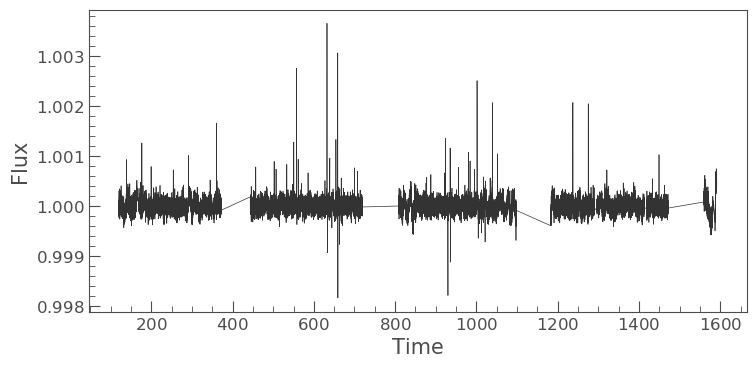

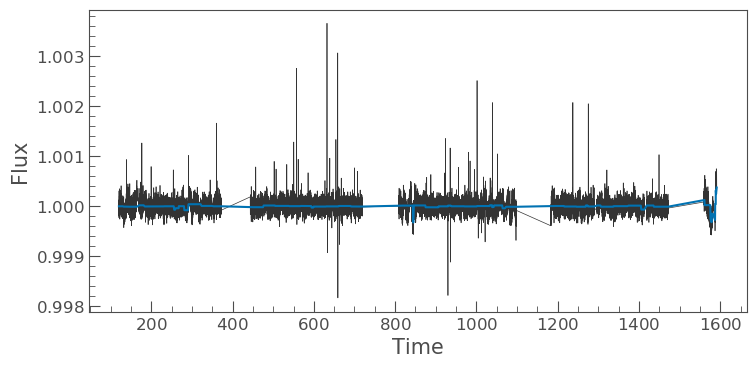

In [2]:
#Define which KOI we will get the LC for
ROWNUM = 3
df = pd.read_csv('EarthAnalogs_20191202.csv')
row = df.iloc[ROWNUM]
koi = row['KOI']
lcpath = f'hz_phot/koi{int(koi)}.n/'
path = str(os.listdir(lcpath)[0])
stitched_lc_df = Table.read(lcpath+path,format = 'ascii') 
stitched_lc = lk.LightCurve(time=stitched_lc_df['col1']-54832.5,flux=stitched_lc_df['col2']+1,flux_err = stitched_lc_df['col3'])
stitched_lc.plot()
params = df.iloc[ROWNUM]
transit_mask = np.logical_or((stitched_lc.time-(params['Epoch']+67))%params['period']>params['period']-params['tdur']/24.0, (stitched_lc.time-(params['Epoch']+67))%params['period']<params['tdur']/24.0)
#take the data +/- 24 hours surrounding the transit
clean_lc,trend_lc = stitched_lc.flatten(window_length=10001,polyorder = 0,return_trend=True, mask=transit_mask)
clean_lc, mask = stitched_lc.remove_outliers(sigma = 20, sigma_upper=5, return_mask=True)
time_trend,flux_trend = trend_lc.time, trend_lc.flux
stitched_lc.plot()
plt.plot(time_trend,flux_trend)


In [94]:
def get_lc_ranges(params, lc):
    """ chop out 1 days on each side of every transit in a given lightcurve, given a set of planet parameters"""
    relevant_data = []
    time = lc.time
    flux = lc.flux
    flux_err = lc.flux_err
    transit_time = params['Epoch']+67
    transit_list = []
    while transit_time <= time[-1]:
        mask = np.logical_and(lc.time > transit_time-1.0, lc.time < transit_time+1.0)
        relevant_data.append([time[mask],flux[mask],flux_err[mask]])
        if list(time[mask]):
            transit_list.append(transit_time)
        transit_time += params['period']
    return np.array(relevant_data),transit_list

In [96]:
data,ranges = get_lc_ranges(df.iloc[ROWNUM],clean_lc)
times = []
fluxes = []
flux_errs = []
for sublist in data:
    times.append(sublist[0])
    fluxes.append(sublist[1])
    flux_errs.append(sublist[2])
times = np.array(times)
fluxes = np.array(fluxes)
flux_errs = np.array(flux_errs)
times = np.hstack(times).ravel()
fluxes = np.hstack(fluxes).ravel()
fluxes_errs = np.hstack(flux_errs).ravel()

### Initializing the Fit:
Let's start by defining some helper functions for the transit model and get some stellar parameters that we use for priors.

In [5]:
import pandas as pd
import limbdark

#helper functions for prior transformations:
def normed(arr):
    mean = np.mean(arr)
    sd = np.std(arr)
    arr -= mean
    arr /= sd
    return (arr,mean,sd)
def mjrxs(per,mass):
    return np.cbrt((mass*per**2)/(4*np.pi**2))
def u_to_q(u1,u2):
    q1 = (u1 + u2)**2
    q2 = 0.5*u1*(u1 + u2)**(-1)
    return q1,q2
def incl(b,a,ecc=0,omega=90):
    ecc_factor = (1. + ecc*np.sin(omega))/(1. - ecc**2)
    inc_inv_factor = (b/a)*ecc_factor
    inc = np.arccos(inc_inv_factor)*180./np.pi
    return inc
def reverse_bp(r1,r2,pl,pu):
    Ar = (pu - pl)/(2. + pl + pu)
    if r1 > Ar:
        b,p = (1+pl)*(1. + (r1-1.)/(1.-Ar)),\
                        (1-r2)*pl + r2*pu
    else:
        b,p = (1. + pl) + np.sqrt(r1/Ar)*r2*(pu-pl),\
            pu + (pl-pu)*np.sqrt(r1/Ar)*(1.-r2)
    return b,p
def q_to_u(q1, q2): 
    u1 = 2.*np.sqrt(np.abs(q1))*q2
    u2 = np.sqrt(np.abs(q1))*(1.-2.*q2)
    return u1,u2
def b(a, i):
    return a*np.cos(i)

def func_rho(per, a):
    #period in days, convert to seconds
    per = per*86400
    G=6.67430e-11 #G in mks
    return 3*np.pi*a**3/(G*per**2)
def a_fn(per,rho):
    G=6.67430e-11 #G in mks

    return ((rho*G*((per*24.*3600.)**2))/(3.*np.pi))**(1./3.)
def mjrxs(per,mass):
    return np.cbrt((mass*per**2)/(4*np.pi**2))


#limbdark takes teff, teff error, logg, logg error, feh, and feh error to compute limb darkening parameters
#Take these quantities from the table of stellar parameters

df_stdata = pd.read_csv('GKSPC_InOut_V4.csv')
row = df.iloc[ROWNUM]
KIC = row['KIC']
mask = df_stdata['KIC']==KIC
rho = float(df_stdata['iso_rho'][mask])
rho_1 = df_stdata['iso_rho_err1'][mask]
rho_2 = df_stdata['iso_rho_err2'][mask]

teff = float(df_stdata['iso_teff'][mask])
teff_1 = float(df_stdata['iso_teff_err1'][mask])
teff_2 = abs(float(df_stdata['iso_teff_err2'][mask]))
teff_e = np.mean([teff_1,teff_2])

logg = float(df_stdata['iso_logg'][mask])
logg_1 = float(df_stdata['iso_logg_err1'][mask])
logg_2 = abs(float(df_stdata['iso_logg_err2'][mask]))
logg_e = np.mean([logg_1,logg_2])

feh = float(df_stdata['iso_feh'][mask])
feh_1 = float(df_stdata['iso_feh_err1'][mask])
feh_2 = abs(float(df_stdata['iso_feh_err2'][mask]))
feh_e = np.mean([feh_1,feh_2])
teffarg = f'{teff},{teff_e}'
#plug into limbdark
a = limbdark.claret('Kp', teff,teff_e,logg,logg_e,feh,feh_e)
def q_to_u(u1,u2):
    q1 = (u1 + u2)**2
    q2 = 0.5*u1*(u1 + u2)**(-1)
    return q1,q2
rhoe = np.mean([float(rho_1), abs(float(rho_2))])
#read off limb darkening parameters
u1,u1e,u2,u2e = a
#convert from u to q
u1_dist = np.random.normal(u1, u1e, 1000000)
u2_dist = np.random.normal(u2, u2e, 1000000)
q1_dist,q2_dist = q_to_u(u1_dist,u2_dist)
q1,q2 = np.mean(q1_dist),np.mean(q2_dist)
q1e,q2e = np.std(q1_dist),np.std(q2_dist)
print(f'KIC {KIC}')
print(f'q1 = {round(q1,3)} +/- {round(q1e,3)}')
print(f'q2 = {round(q2,3)} +/- {round(q2e,3)}')
print(f"rho = {round(rho,3)} +/- {round(rhoe,3)}")

KIC 11804437
q1 = 0.421 +/- 0.057
q2 = 0.284 +/- 0.017
rho = 0.842 +/- 0.091


### Fitting with Juliet:
Start by loading priors and data

In [6]:
jtime, jflux, jflux_errs = {},{},{}
jtime['Kepler'] = times
jflux['Kepler'] = fluxes
jflux_errs['Kepler'] = fluxes_errs
row = df.iloc[ROWNUM]

KIC = row['KIC']
parameters = ['P_p1','t0_p1','p_p1','b_p1','q1_Kepler','q2_Kepler','ecc_p1','omega_p1',\
              'rho', 'mdilution_Kepler', 'mflux_Kepler', 'sigma_w_Kepler']
dists = ['uniform','uniform','uniform','normal','normal','normal','fixed','fixed',\
                 'normal', 'fixed', 'fixed', 'loguniform']
hyperps = [[row['period']-row['period_e']*3,row['period']+row['period_e']*3], [row['Epoch']+67-row['Epoch_e']*3,row['Epoch']+67+row['Epoch_e']*3], [row['RpRs'],np.mean([row['RpRs_p'],-row['RpRs_m']])*3], [row['b'],1.], [q1, q1e], [q2, q2e], 0.0, 90.,\
                   [rho*1000, rhoe*1000], 1.0, 0., [0.1, 1000.]]
priors = {}
for param, dist, hyperp in zip(parameters, dists, hyperps):
    priors[param] = {}

    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp
    
dataset = juliet.load(priors=priors, t_lc = jtime, y_lc = jflux, \
                   yerr_lc = jflux_errs, out_folder = f'{KIC}')


Fit and report evidence:

In [7]:
results = dataset.fit()

0it [00:00, ?it/s]

PyMultinest installation not detected. Forcing dynesty as the sampler.


24054it [11:27, 34.97it/s, batch: 9 | bound: 260 | nc: 1 | ncall: 564340 | eff(%):  4.262 | loglstar: 2225.249 < 2235.593 < 2233.451 | logz: 2225.827 +/-    nan | stop:  0.930]     


In [8]:
lnz = results.posteriors['lnZ']
lnz_err = results.posteriors['lnZerr']
print("lnZ for transit model from Juliet is:", round(lnz,2), "+-",round(lnz_err,2))

lnZ for transit model from Juliet is: 2225.82 +- nan


### Fit with Dynesty:
Begin by initializing the batman model and defining loglike and prior transform functions.

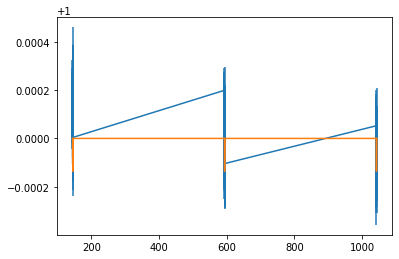

In [9]:
import batman
import scipy.stats as stats
import numpy as np
a = a_fn(row['period'],rho*1000)
params = batman.TransitParams()
params.t0 = row['Epoch']+67           #time of inferior conjunction
params.per = row['period']            #orbital period
params.rp = row['RpRs']               #planet radius (in units of stellar radii)
params.a = a
params.inc = incl(0,a)              #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = list(q_to_u(q1,q2))
t = np.array(times)  #times at which to calculate light curve
f = np.array(fluxes)
fe = np.array(fluxes_errs)
m = batman.TransitModel(params, t)
flux_model=m.light_curve(params)
plt.errorbar(t,f,fe)

plt.plot(t,flux_model,zorder=10)
plt.show()

transits = 4

#log likelihood function
def loglike(theta):
    t0, per, b, rp, prho, pq1, pq2, sigma_w = theta
    a = a_fn(per,prho)
    params.t0 = t0                       #time of inferior conjunction
    params.per = per                     #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = a                        #semi-major axis (in units of stellar radii)
    params.inc = incl(b,a)              #orbital inclination (in degrees)
    params.limb_dark = "quadratic"       #limb darkening model
    params.u = list(q_to_u(pq1,pq2))
    params.rp = rp

    model = m.light_curve(params) 
    inv_sigma2 = 1.0 / (fe**2 + (sigma_w*1e-6)**2)
    
    return -0.5 * (np.sum((f-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

# prior transform
def prior_transform(utheta):
    ut0, uper, ub, urp, urho, uq1, uq2,  usigma_w = utheta
    ux = utheta
    t0 = ((ut0-0.5)*(row['Epoch_e'])*3) + row['Epoch']+67
    per = ((uper-0.5)*(row['period_e'])*3) + row['period']
    b = stats.norm.ppf(ub, loc=row['b'], scale = 1.)
    rp = (stats.norm.ppf(urp, loc = row['RpRs'], scale = np.mean([row['RpRs_p'],-row['RpRs_m']])*3))
    prho = stats.norm.ppf(urho,loc = rho*1000, scale = rhoe*1000)
    pq1 = stats.norm.ppf(uq1,loc = q1, scale = q1e)
    pq2 = stats.norm.ppf(uq2,loc = q2, scale = q2e)

    sigma_w = stats.loguniform.ppf(usigma_w,0.1,1000)
    return t0, per, b, rp, prho, q1, q2, sigma_w

Fit with dynesty and report model evidence.

In [10]:
dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=8, bound='multi')
dsampler.run_nested()
dres = dsampler.results

19006it [09:16, 34.17it/s, batch: 8 | bound: 281 | nc: 5 | ncall: 245434 | eff(%):  7.744 | loglstar: 2496.006 < 2503.475 < 2502.139 | logz: 2495.513 +/-  0.138 | stop:  0.998]        


In [11]:
print("lnZ for transit model from Juliet is:", round(dres.logz[-1],2))#, "+-",round(lnz_err,2))

lnZ for transit model from Juliet is: 2495.47


### Plotting:
Plot the data with the fit.

<IPython.core.display.Javascript object>


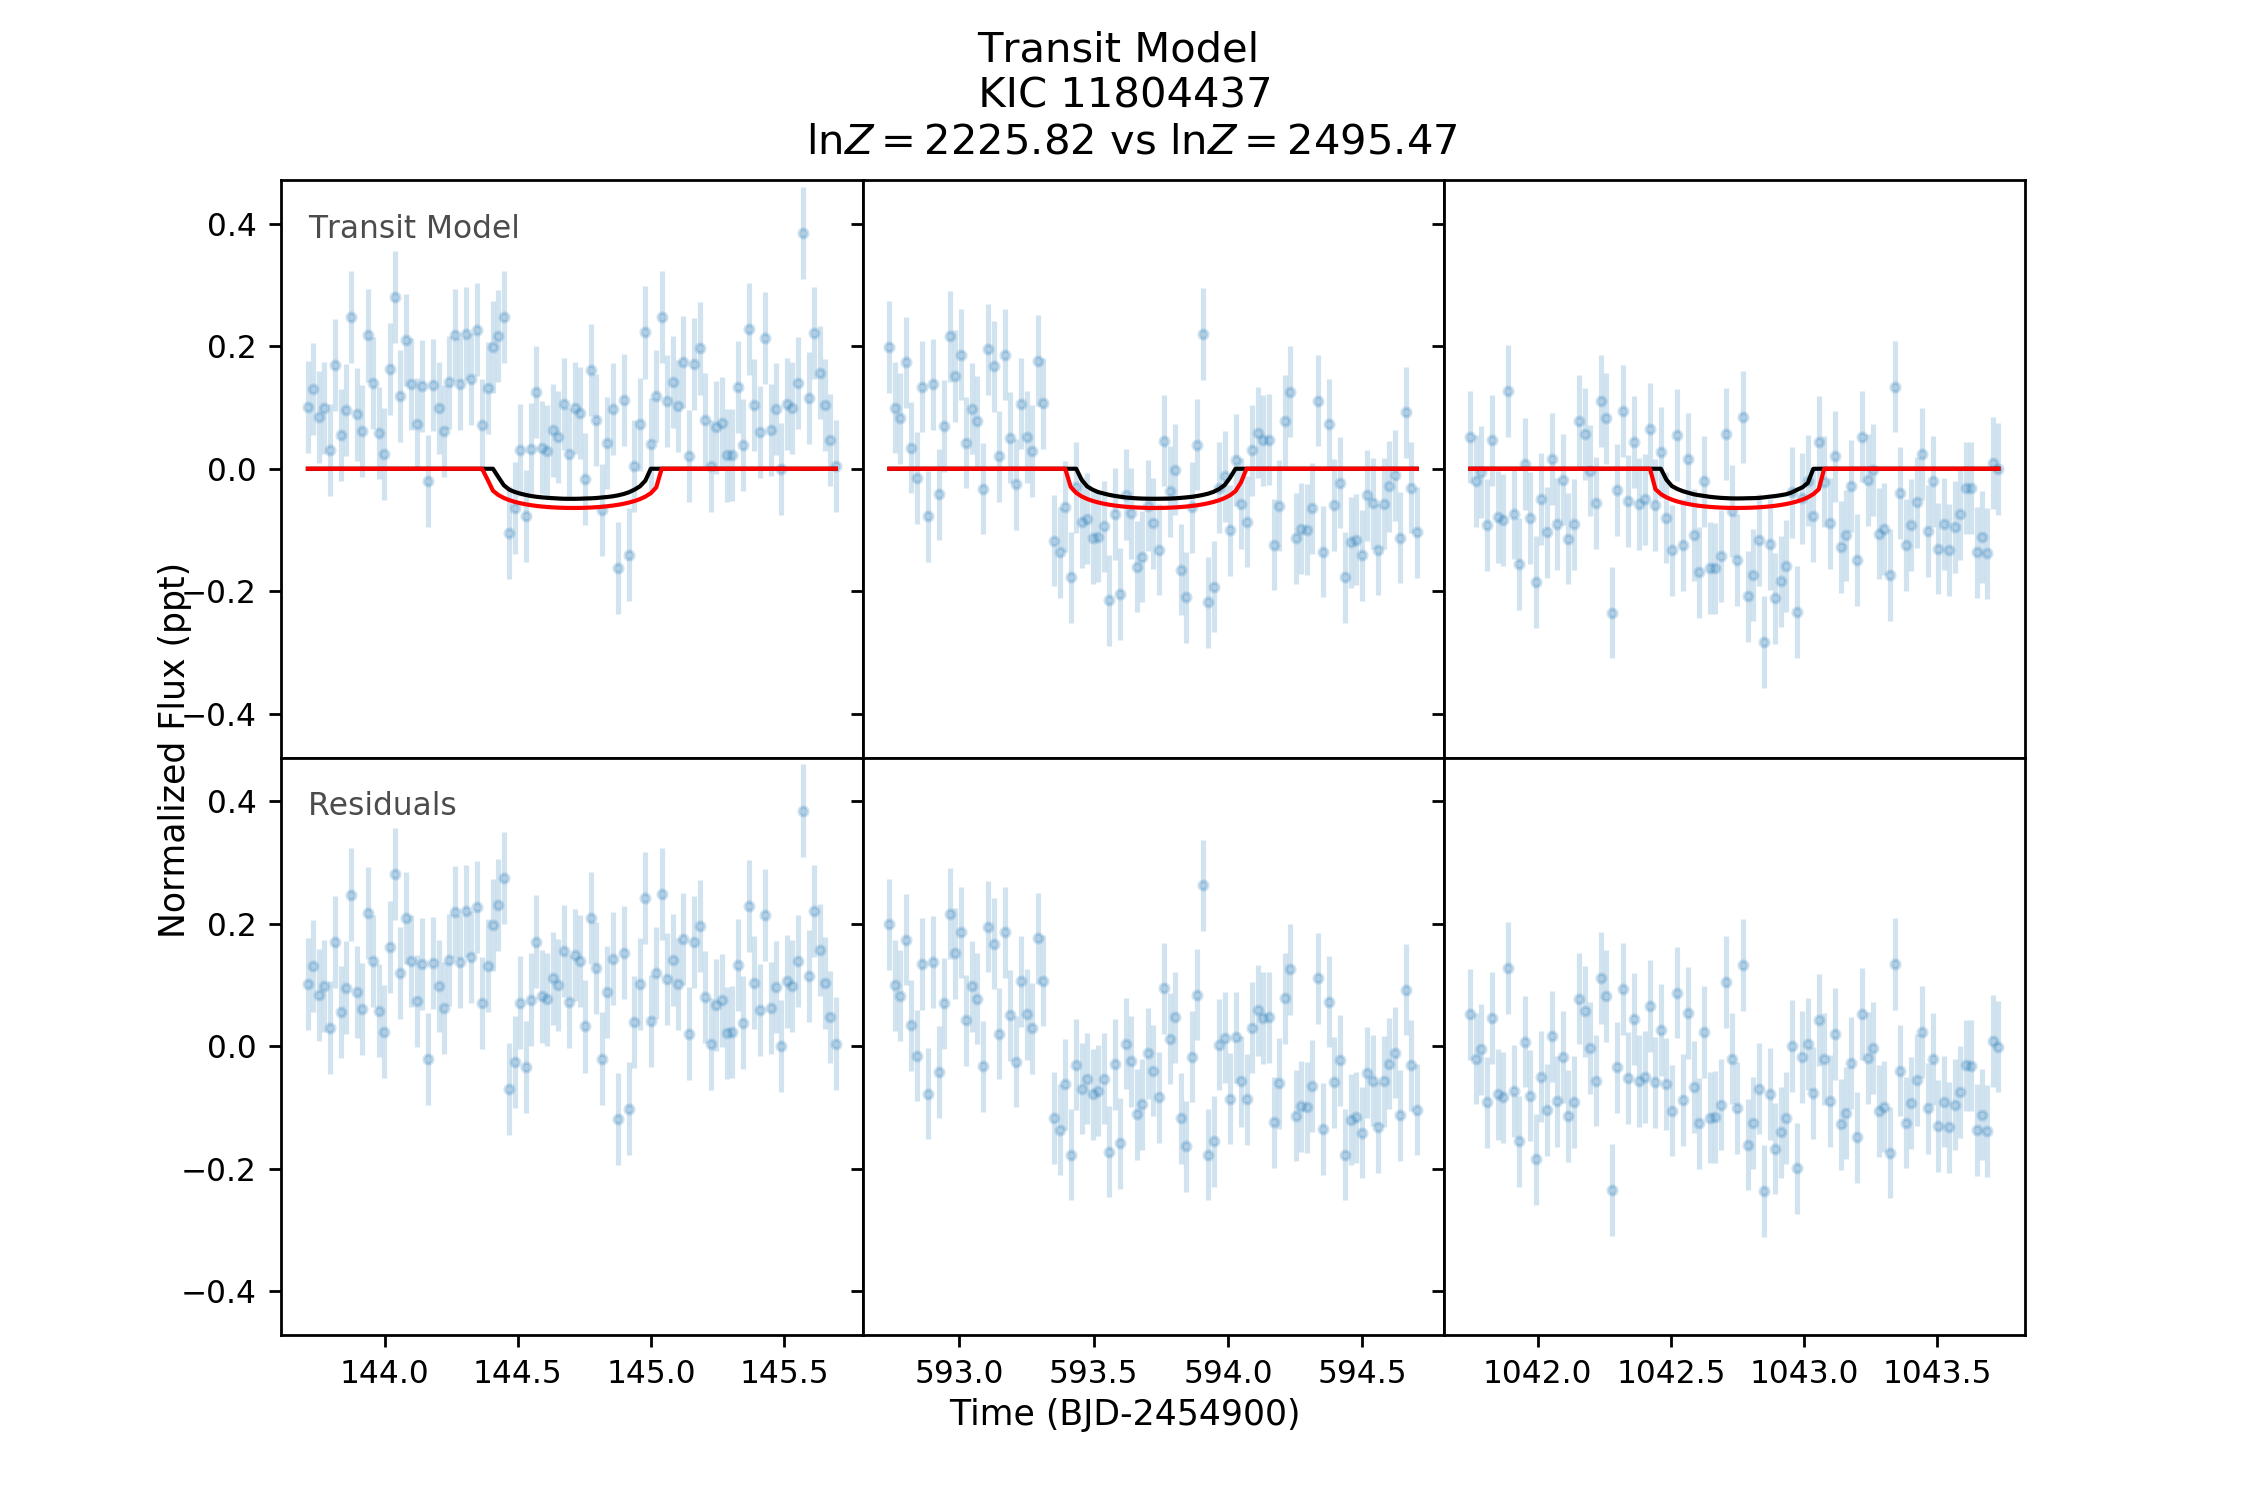

In [105]:
%matplotlib notebook
# Extract full Juliet model:
juliet_model = results.lc.evaluate('Kepler')

#Batman
samples, weights = dres.samples, np.exp(dres.logwt - dres.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)
m_t0, m_per, m_b, m_rp, m_rho, m_q1, m_q2, m_sigma_w = mean
m_a = a_fn(m_per,m_rho/1000)
params = batman.TransitParams()

params.t0 = row['Epoch']+67           #time of inferior conjunction
params.per = row['period']            #orbital period
params.rp = row['RpRs']              #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.0, 0.0]
m = batman.TransitModel(params, t)

m_a = a_fn(m_per,m_rho)
params.t0 = m_t0                       #time of inferior conjunction
params.per = m_per                     #orbital period
params.rp = m_rp                       #planet radius (in units of stellar radii)
params.a = m_a                        #semi-major axis (in units of stellar radii)
params.inc = incl(m_b,m_a)              #orbital inclination (in degrees)
params.limb_dark = "quadratic"       #limb darkening model
params.u = list(q_to_u(m_q1,m_q2))
params.rp = m_rp

dynesty_model = m.light_curve(params)



scale = 1000
ylimits = [-np.std(dataset.data_lc['Kepler'])*4*scale,np.std(dataset.data_lc['Kepler'])*4*scale]
transits = len(ranges)
# Now plot. First preambles:
fig = plt.figure(figsize=(transits*3,3*2),tight_layout = True)
fig.suptitle(f'Transit Model \n KIC {KIC} \n $\ln{{Z}}= {round(lnz, 2)}$ vs $\ln{{Z}}= {round(dres.logz[-1], 2)}$',fontsize = 12)
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Normalized Flux')
gs = gridspec.GridSpec(2, transits, wspace = 0, hspace = 0)
for i in range(transits):        
        ax1 = plt.subplot(gs[0,i])
        # Plot data
        t = np.array(dataset.times_lc['Kepler'])

        mask = np.logical_and(t >= ranges[i]-1.0, t <= ranges[i]+1.0)
        x_range = t[mask]
        idxs = np.where(mask)
        ax1.errorbar(x_range, dataset.data_lc['Kepler'][idxs]*scale-scale, \
            yerr = dataset.errors_lc['Kepler'][idxs]*scale, fmt = '.', alpha = 0.2)

        # Plot both transit models:
        ax1.plot(x_range, juliet_model[idxs]*scale-scale,linewidth = 1.2, color='black',zorder=11, label = 'Juliet')
        ax1.plot(x_range, dynesty_model[idxs]*scale-scale,linewidth = 1.2, color='red',zorder=12, label = 'Dynesty')

        #ax1.axvspan(min(fillrange),max(fillrange),color = 'red',alpha = 0.1)
        xlims = [min(x_range)-0.1,max(x_range)+0.1]
        ax1.set_xlim(xlims)
        ax1.set_ylim(ylimits)
        ax1.text(min(t),(ylimits[1])*.8,'Transit Model', alpha = 0.7)

        ax3 = plt.subplot(gs[1,i])
        # Plot resids
        ax3.errorbar(x_range, (dataset.data_lc['Kepler'][idxs]/juliet_model[idxs])*scale-scale, \
            yerr = scale*dataset.errors_lc['Kepler'][idxs], fmt = '.', alpha = 0.2)

        #ax1.axvspan(min(fillrange),max(fillrange),color = 'red',alpha = 0.1)
        xlims = [min(x_range)-0.1,max(x_range)+0.1]
        ax3.set_xlim(xlims)
        ax3.set_ylim(ylimits)
        ax3.text(min(t),(ylimits[1])*.8,'Residuals', alpha = 0.7)


all_axes = fig.get_axes() 
for ax in all_axes:
    ax.label_outer()
    ax.locator_params(nbins=5, axis='x')
    ax.locator_params(nbins=5, axis='y')


fig.text(0.5, 0.05, 'Time (BJD-2454900)', ha='center', fontsize = 10)
fig.text(0.07, 0.5, 'Normalized Flux (ppt)', va='center', rotation='vertical', fontsize = 10)
#plt.xlabel('Time (BJD-2454900)')
#plt.ylabel('Normalized Flux')
plt.savefig(f'{KIC}/transit_plot.png',dpi=500)

In [88]:
t = np.array(dataset.times_lc['Kepler'])
mask = np.logical_and(t >= ranges[3]-1.0, t <= ranges[3]+1.0)

In [93]:
max(times)

1043.7290055296035

In [97]:
max(ranges)

1042.7352811599999